#  Intracranial Hemorrhage Detection

## Model 1

#### Kristina Joos

---   

|                 	|                                                        	|
|:----------------:	|:-------------------------------------------------------:	|
| Model           	| 2 x (Conv2D + MaxPool) + 2 Dense                   |
| Preprocessing   	| Augementation Flip                 	|
| Class Balancing 	| Oversampling (2:1)                                          	|
| Loss Function   	| Weighted Log Loss                                	|
| Regularization  	| Drop Out Layers 0.5	                    |
| Epochs Run      	| 14                                                    	|
| Time Run (h)   	| 3                                                   	|
|                 	|                                                        	|
| Test Sores      	| Loss: 0.3614                             |
| Validation      	| Loss: 0.3276                            |
| Leader Board    	| Score: 0.50632 Rank: 410/1345 (31%)                     	|




## Imports

In [180]:
import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from math import ceil, floor, log
import cv2
import sys

from skimage.transform import resize
from imgaug import augmenters as iaa
 
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg_16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout, MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.initializers import glorot_normal, he_normal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model, Sequential, load_model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam




## Check GPU availability

In [4]:
tf.test.is_gpu_available()

True

In [5]:

tf.test.is_built_with_cuda()

True

## Image Path

In [6]:
test_images_dir = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_test/'
train_images_dir = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train/'



## Preprocessing

<div style="font-size: 12px"> 
    
Code adapted from: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly(last visited Nov. 24, 2019).  
Code adapted from Allunia: https://www.kaggle.com/allunia/rsna-ih-detection-eda(last visited Nov. 24, 2019).   


In [7]:
# Function rescale Pixel Array to HU unites
def rescale_image(dataset):
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    rescaled_image[rescaled_image < -1024] = -1024
    return rescaled_image

# Function for windowing: getting rid of informations in the image we don't need (CT-tube signals,
# bones and tissue we are not interested in.)
def windowing(hu_image, image_min, image_max):
    hu_image = np.clip(hu_image, hu_min_value, hu_max_value)
    hu_image = np.where(hu_image<hu_min_value,hu_min_value, hu_image)
    hu_image = np.where(hu_image>hu_max_value, hu_max_value, hu_image)
    return hu_image

class Preprocessor:    
    
    def __init__(self, path,hu_min_value, hu_max_value, augment=False):
        self.path = path
        self.nn_input_shape = (512, 512) 
        self.hu_min_value = hu_min_value
        self.hu_max_value = hu_max_value
        self.augment = augment
        
    # Load dicom file.
    def load_dicom_dataset(self, filename):
        dataset = pydicom.dcmread(self.path + filename)
        return dataset
    
    # Rescale and windowing function put together.
    def get_hounsfield_window(self, dataset, min_value, max_value):
        
        hu_image = rescale_image(dataset)
        windowed_image = windowing(hu_image, min_value, max_value)
 
        return windowed_image

    # Resize the image to the input shape of the CNN.
    def resize(self, image):
        image = resize(image, self.nn_input_shape)
        return image

    # Augementation Function: Crop, rotate and flip horizontally
    def augment_img(self, image): 
        augment_img = iaa.Sequential([
            #iaa.Crop(keep_size=True, percent=(0.01, 0.05), sample_independently=False),
            #iaa.Affine(rotate=(-10, 10)),
            iaa.Fliplr(0.5)])
        image_aug = augment_img.augment_image(image)
        return image_aug
    
    def fill_channels(self, image):
        filled_image = np.stack((image,)*3, axis=-1)
        return filled_image
    
    def preprocess(self, identifier):
        filename = identifier +  ".dcm"
        dataset = self.load_dicom_dataset(filename)
        windowed_image = self.get_hounsfield_window(dataset, self.hu_min_value, self.hu_max_value)
        image = self.resize(windowed_image)
        if self.augment:
            image = self.augment_img(image)
        image = self.fill_channels(image)
        return image
    
    def normalize(self, image):
        return (image - self.hu_min_value)/(self.hu_max_value-self.hu_min_value) * 0.5


In [8]:
class DataLoader(Sequence):
    
    def __init__(self, dataframe,
                 preprocessor,
                 batch_size,
                 shuffle,
                 num_classes=6,
                 steps=None):
        
        self.preprocessor = preprocessor
        self.data_ids = dataframe.index.values
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = (512, 512) #was 256,256
        #self.preprocess_fun = self.preprocessor.backbone["preprocess_fun"]
        self.num_classes = num_classes
        self.current_epoch=0
        
        self.steps=steps
        if self.steps is not None:
            self.steps = np.round(self.steps/3) * 3
            self.oversample()

    def oversample(self):
        part = np.int(self.steps/3 * self.batch_size)
        zero_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 0].index.values, size=2*part, replace=False)
        hot_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 1].index.values, size=1*part, replace=False)
        self.data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(self.data_ids)

    # defines the number of steps per epoch
    def __len__(self):
        if self.steps is None:
            return np.int(np.ceil(len(self.data_ids) / np.float(self.batch_size)))
        else:
            return 3*np.int(self.steps/3) 
    
    # at the end of an epoch: 
    def on_epoch_end(self):
        # if steps is None and shuffle is true:
        if self.steps is None:
            self.data_ids = self.dataframe.index.values
            if self.shuffle:
                np.random.shuffle(self.data_ids)
        else:
            self.oversample()
        self.current_epoch += 1
    
    # should return a batch of images
    def __getitem__(self, item):
        # select the ids of the current batch
        current_ids = self.data_ids[item*self.batch_size:(item+1)*self.batch_size]
        X, y = self.__generate_batch(current_ids)
        return X, y
    
    
    
    # collect the preprocessed images and targets of one batch
    def __generate_batch(self, current_ids):
        X = np.empty((self.batch_size, *self.input_shape, 3))
        y = np.empty((self.batch_size, self.num_classes))
        for idx, ident in enumerate(current_ids):
            # Store sample
            image = self.preprocessor.preprocess(ident)
            X[idx] = self.preprocessor.normalize(image)
            # Store class
            y[idx] = self.__get_target(ident)
        return X, y
    
    # extract the targets of one image id:
    def __get_target(self, ident):
        targets = self.dataframe.loc[ident].values
        return targets

## Meta Data

In [93]:
# path to train and test images
test_images_dir = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_test/'
train_images_dir = '../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train/'

In [94]:
# Make usable data frames
train_df = pd.read_csv('../data/input/rsna-intracranial-hemorrhage-detection/stage_2_train.csv')
train_df.head(7)

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
5,ID_12cadc6af_any,0
6,ID_38fd7baa0_epidural,0


In [95]:
# Test submission as test 
test_df = pd.read_csv('../data/input/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv')
test_df.head(7)

,ID,Label
0,ID_0fbf6a978_epidural,0.5
1,ID_0fbf6a978_intraparenchymal,0.5
2,ID_0fbf6a978_intraventricular,0.5
3,ID_0fbf6a978_subarachnoid,0.5
4,ID_0fbf6a978_subdural,0.5
5,ID_0fbf6a978_any,0.5
6,ID_d62ec3412_epidural,0.5


In [96]:
label = train_df.Label.values
train_df = train_df.ID.str.rsplit("_", n=1, expand=True)
train_df.loc[:, "label"] = label
train_df = train_df.rename({0: "id", 1: "subtype"}, axis=1)
train_df.head()


,id,subtype,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [97]:
label = test_df.Label.values
test_df = test_df.ID.str.rsplit("_", n=1, expand=True)
test_df.loc[:, "label"] = label
test_df = test_df.rename({0: "id", 1: "subtype"}, axis=1)
test_df.head()

,id,subtype,label
0,ID_0fbf6a978,epidural,0.5
1,ID_0fbf6a978,intraparenchymal,0.5
2,ID_0fbf6a978,intraventricular,0.5
3,ID_0fbf6a978,subarachnoid,0.5
4,ID_0fbf6a978,subdural,0.5


In [98]:
train_df.shape

(4516842, 3)

In [99]:
test_df.shape

(727392, 3)

In [100]:
train_df = pd.pivot_table(train_df, index="id", columns="subtype", values="label")
train_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0


In [101]:
test_df = pd.pivot_table(test_df, index="id", columns="subtype", values="label")
test_df.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000000e27,0.5,0.5,0.5,0.5,0.5,0.5
ID_000009146,0.5,0.5,0.5,0.5,0.5,0.5
ID_00007b8cb,0.5,0.5,0.5,0.5,0.5,0.5
ID_000134952,0.5,0.5,0.5,0.5,0.5,0.5
ID_000176f2a,0.5,0.5,0.5,0.5,0.5,0.5


In [102]:
train_df.shape


(752803, 6)

In [103]:
test_df.shape

(121232, 6)

## Train_Test_Split

In [21]:
#Provides train/test indices to split data in train/test sets.

# This cross-validation object is a variation of KFold that returns
# stratified folds. The folds are made by preserving the percentage of
# samples for each class.

kfold = StratifiedKFold(n_splits=5, random_state=234).split(X=np.arange(train_df.shape[0]), y=train_df["any"].values)

train_idx, val_idx = next(kfold)

train_data = train_df.iloc[train_idx]
val_data = train_df.iloc[val_idx]

#train_data, dev_data = train_test_split(traindf, test_size=0.1, stratify=traindf.values, random_state=split_seed)
print(train_data.shape)
print(val_data.shape)


(602242, 6)
(150561, 6)


## Instantiate Preprocessor and DataLoader

In [22]:
train_preprocessor = Preprocessor(path=train_images_dir,
                                  hu_min_value=0,
                                  hu_max_value=100,
                                  augment=True)

In [23]:
val_preprocessor = Preprocessor(path=train_images_dir,
                                hu_min_value=0,
                                hu_max_value=100,
                                augment=False)


In [24]:
test_preprocessor = Preprocessor(path=test_images_dir,
                                hu_min_value=0,
                                hu_max_value=100,
                                augment=False)

In [65]:
train_dataloader = DataLoader(train_data,
                              train_preprocessor,
                              128,
                              shuffle=True,
                              steps=50)

val_dataloader = DataLoader(val_data, 
                            val_preprocessor,
                            128,
                            shuffle=True,
                            steps=50)

test_dataloader = DataLoader(test_df, 
                             test_preprocessor,
                             4,
                             shuffle=False)

In [30]:
train_dataloader.__len__()

51

In [31]:
len(train_dataloader.data_ids)/128

51.0

In [32]:
test_dataloader.__len__()

948

In [33]:
len(test_dataloader.data_ids)/128

947.125

In [34]:
train_data.shape

(602242, 6)

In [35]:
len(train_dataloader.data_ids)

6528

In [36]:
train_data.loc[train_dataloader.data_ids]["any"].value_counts()


0    4352
1    2176
Name: any, dtype: int64

## Custom Loss Function
Loss Functions from here https://www.kaggle.com/akensert/inceptionv3-prev-resnet50-keras-baseline-model:

In [37]:
# from keras import backend as K
def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)


def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)


def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

## Build Model

In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters = 16,
                    kernel_size = (3,3),
                    activation = 'relu',
                    input_shape = (512, 512, 3))) #was 256,256

cnn_model.add(MaxPooling2D(pool_size = (2,2)))

cnn_model.add(Conv2D(64, 
                    kernel_size = (3,3),
                    activation = 'relu'))

cnn_model.add(MaxPooling2D(pool_size = (2,2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(64, activation = 'relu'))

cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(32, activation = 'relu'))

cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(6, activation='sigmoid'))

cnn_model.compile(loss=weighted_loss, optimizer='adam', metrics=['accuracy'])

In [40]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 64)      9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1016064)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                65028160  
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [41]:
# Set callback functions to early stop training and save the best model so far
my_callbacks = [EarlyStopping(monitor='val_accuracy', patience=10),
             ModelCheckpoint(filepath='../models/mymodels/cnn_model.h5', monitor='val_accuracy', save_best_only=True)]

In [42]:
history = cnn_model.fit_generator(generator=train_dataloader,
                    validation_data=val_dataloader,
                    use_multiprocessing=True,
                    workers=12,epochs = 100,verbose = 2, callbacks = my_callbacks)

Epoch 1/100
51/51 - 381s - loss: 0.7571 - accuracy: 0.0847 - val_loss: 0.6720 - val_accuracy: 0.0000e+00
Epoch 2/100
51/51 - 270s - loss: 0.6316 - accuracy: 0.0542 - val_loss: 0.4680 - val_accuracy: 0.0012
Epoch 3/100
51/51 - 257s - loss: 0.5231 - accuracy: 0.2655 - val_loss: 0.3929 - val_accuracy: 0.8923
Epoch 4/100
51/51 - 257s - loss: 0.4657 - accuracy: 0.4458 - val_loss: 0.3714 - val_accuracy: 1.0000
Epoch 5/100
51/51 - 259s - loss: 0.4401 - accuracy: 0.6144 - val_loss: 0.3538 - val_accuracy: 1.0000
Epoch 6/100
51/51 - 267s - loss: 0.4222 - accuracy: 0.7209 - val_loss: 0.3582 - val_accuracy: 1.0000
Epoch 7/100
51/51 - 268s - loss: 0.4029 - accuracy: 0.7886 - val_loss: 0.3369 - val_accuracy: 1.0000
Epoch 8/100
51/51 - 271s - loss: 0.3901 - accuracy: 0.8416 - val_loss: 0.3407 - val_accuracy: 1.0000
Epoch 9/100
51/51 - 266s - loss: 0.3811 - accuracy: 0.8824 - val_loss: 0.3343 - val_accuracy: 1.0000
Epoch 10/100
51/51 - 268s - loss: 0.3783 - accuracy: 0.9024 - val_loss: 0.3339 - val_ac

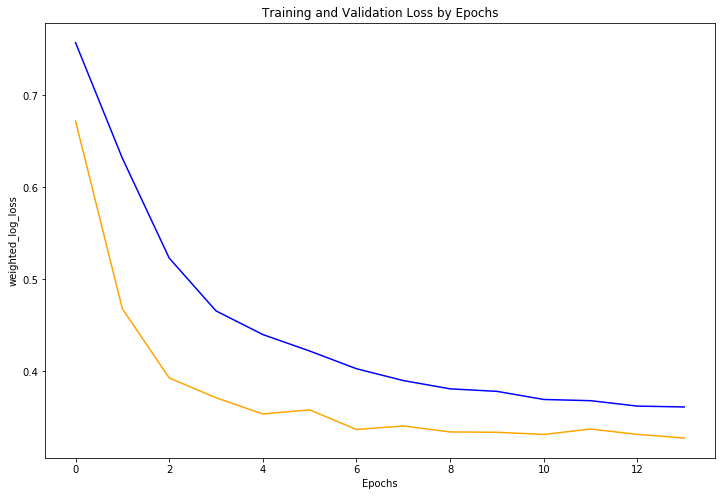

In [43]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (12,8))

plt.plot(train_loss, label = 'training_loss', color = 'b')
plt.plot(val_loss, label = 'val_loss', color = 'orange')

plt.title('Training and Validation Loss by Epochs')
plt.xlabel('Epochs')
plt.ylabel('weighted_log_loss');

## Make Predictions

In [71]:
def make_df(meta_data_df, predictions):
    df = pd.DataFrame(predictions, columns=meta_data_df.columns, index=meta_data_df.index)
    df = df.stack().reset_index()
    df.loc[:, "ID"] = df.id.str.cat(df.subtype, sep="_")
    df = df.drop(["id", "subtype"], axis=1)
    df = df.rename({0: "Label"}, axis=1)
    return df

In [66]:
test_predictions_batch_size_4 = cnn_model.predict_generator(test_dataloader,use_multiprocessing=True, workers = -1)

In [105]:
test_pred_df = make_df(test_df, test_predictions_batch_size_4)

In [108]:
test_pred_df = test_pred_df[['ID','Label']]

In [109]:
test_pred_df.to_csv('../data/output/submissions/submission_model_1.csv', index=False)

In [127]:

val_pred_dataloader = DataLoader(val_data, 
                            val_preprocessor,
                            9, shuffle = False)

In [128]:
val_predictions = cnn_model.predict_generator(val_pred_dataloader, use_multiprocessing=True, workers = -1)

In [233]:
val_pred_df = make_df(val_data, val_predictions)